In [1]:
import pandas as pd
import seaborn as sns; sns.set(font_scale=2); sns.set_style("ticks")
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

In [3]:
import os; os.getcwd()

'/home/conradin/projects/master_20/dmsseq_sacc/scripts'

In [12]:
def read_wiggle(path):
    f = pd.read_csv(
            path,
            sep=" ",
            skiprows=1,
            names=["pos", "score"]
    )
    return(f)

In [13]:
master_df = pd.DataFrame()

# initialize the samples list with the free DNA from the virus samples
samples = [
    "../../dms_Ad_norm/raw_footprint/DMS_footprint/AdWT_free_DMS_2_footprint.wig",
    "../../dms_Ad_norm/raw_footprint/DMS_footprint/AdWT_free_DMS_1_footprint.wig",
    "../../dms_Ad_norm/raw_footprint/DMS_footprint/AdWT_virus_DMS_1_footprint.wig",
    "../../dms_Ad_norm/raw_footprint/DMS_footprint/AdWT_virus_DMS_2_footprint.wig",
    "../../dms_Ad_norm/raw_footprint/DMS_footprint/AdMUT_virus_ts1_DMS_1_footprint.wig",
    "../../dms_Ad_norm/raw_footprint/DMS_footprint/AdMUT_virus_ts1_DMS_2_footprint.wig"
]

# add the single chromosomes from the yeast
for chrom in "I II III IV V VI VII VIII IX X XI XII XIII XIV XV XVI".split():    
    wiggle = "../data/aligned/footprint/yeast_bar1delta_free/{}.wig".format(chrom)
    samples.append(wiggle)
    wiggle = "../data/aligned/footprint/yeast_bar1delta/{}.wig".format(chrom)
    samples.append(wiggle)
    

for wiggle in samples:
    df = read_wiggle(wiggle)
    
    ## This part only removes extreme values
    # remove extreme values from the footprint
    df["zscore"] = (df["score"] - df["score"].mean()) / df["score"].std(ddof=0)
    # get mean value of all values without outliers
    avg = df.loc[abs(df["zscore"]) < 10,]["score"].mean()
    # replace every value where zscore is above 10 or below -10 with the average
    df = df.where(abs(df["zscore"]) < 10, avg)
    
    
    #### Convert the footprint to array
    score = np.array(df["score"])
    
    
    # calc Periodogram
    freqs, spectrum = signal.welch(
        score,
        window="boxcar",
        scaling="density",
        nfft = 60000,
        detrend = "linear"
    )
    
    temp_df = pd.DataFrame({"freqs":freqs, "spectrum":spectrum})

    temp_df["period"] = 1 / temp_df["freqs"]
        
    temp_df["filename"] = wiggle
    
    if "AdWT_free" in wiggle:
        temp_df["species"] = "ad free"
    elif "AdWT_virus" in wiggle:
        temp_df["species"] = "ad wt"
    elif "AdMUT_virus" in wiggle:
        temp_df["species"] = "ad ts1"
    elif "yeast" in wiggle:
        if "free" in wiggle:
            temp_df["species"] = "yeast free"
        else:
            temp_df["species"] = "yeast"
    
    
    temp_df["norm_spectrum"] = temp_df["spectrum"] / temp_df["spectrum"].sum()
    
    master_df = master_df.append(temp_df) 

In [27]:
df_zoom = master_df.loc[master_df["period"] <= 250,]
df_zoom = df_zoom.loc[df_zoom["period"] >= 0]
df_zoom

,freqs,spectrum,period,filename,species,norm_spectrum
240,0.004000,651.778774,250.000000,../../dms_Ad_norm/raw_footprint/DMS_footprint/...,ad free,0.000031
241,0.004017,655.250809,248.962656,../../dms_Ad_norm/raw_footprint/DMS_footprint/...,ad free,0.000031
242,0.004033,658.665544,247.933884,../../dms_Ad_norm/raw_footprint/DMS_footprint/...,ad free,0.000031
243,0.004050,662.022391,246.913580,../../dms_Ad_norm/raw_footprint/DMS_footprint/...,ad free,0.000031
244,0.004067,665.320784,245.901639,../../dms_Ad_norm/raw_footprint/DMS_footprint/...,ad free,0.000031
...,...,...,...,...,...,...
29996,0.499933,0.022436,2.000267,../data/aligned/footprint/yeast_bar1delta/XVI.wig,yeast,0.000033
29997,0.499950,0.022436,2.000200,../data/aligned/footprint/yeast_bar1delta/XVI.wig,yeast,0.000033
29998,0.499967,0.022437,2.000133,../data/aligned/footprint/yeast_bar1delta/XVI.wig,yeast,0.000033
29999,0.499983,0.022437,2.000067,../data/aligned/footprint/yeast_bar1delta/XVI.wig,yeast,0.000033


/home/conradin/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


KeyboardInterrupt: 

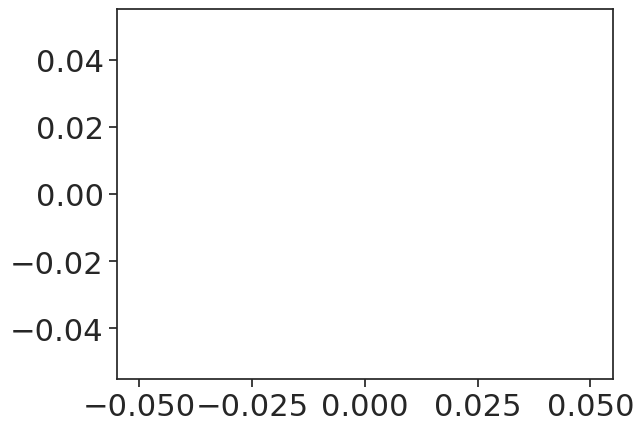

In [28]:
sns.lineplot("period", "norm_spectrum", hue="filename", data = df_zoom, legend = False, ci = None)

In [ ]:
fig, axes = plt.subplots(2, 1, figsize = (5,10))
axes[0].set_title("Spectral Density in Virus and Yeast DNA")
sns.lineplot(
    "period",
    "spectrum",
    hue="species",
    data = df_zoom,
    palette = {
        "ad free":"black",
        "ad wt":"darkmagenta",
        "ad ts1":"deepskyblue",
        "yeast free":"grey",
        "yeast": "green"},
    ax=axes[0],
    linewidth =3
)
axes[1].set_title("NORMALIZED Spectral Density in Virus and Yeast DNA")
sns.lineplot(
    "period",
    "norm_spectrum",
    hue="species",
    data = df_zoom,
    palette = {
        "ad free":"black",
        "ad wt":"darkmagenta",
        "ad ts1":"deepskyblue",
        "yeast free":"green"},
    ax=axes[1],
    linewidth = 3
)
plt.tight_layout()

plt.savefig("../../dms_Ad_norm/plots/periodogram/welch_comparison_virus-free_yeast_yeast_and_virus_ts1.png",dpi=300, bbox_inches="tight")
plt.savefig("../../dms_Ad_norm/plots/periodogram/welch_comparison_virus-free_yeast_yeast_and_virus_ts1.svg",dpi=300, bbox_inches="tight")

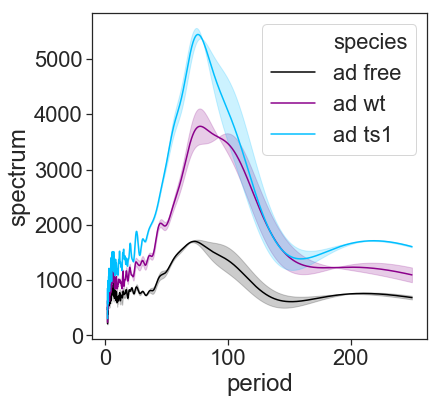

In [13]:
df = df_zoom.loc[df_zoom["species"] != "yeast free"]

# same as above but exclude the yeast DNA
plt.subplots(figsize=(6,6))
sns.lineplot("period", "spectrum", hue="species", data = df, palette = {"ad free":"black", "ad wt":"darkmagenta", "ad ts1":"deepskyblue"})
plt.savefig("../plots/periodogram/free_WT_ts1_welch.png", dpi=300, bbox_inches="tight")
plt.savefig("../plots/periodogram/free_WT_ts1_welch.svg", dpi=300, bbox_inches="tight")

In [15]:
df_free = df_zoom.loc[df_zoom["species"].isin(["ad free", "yeast free"]),]

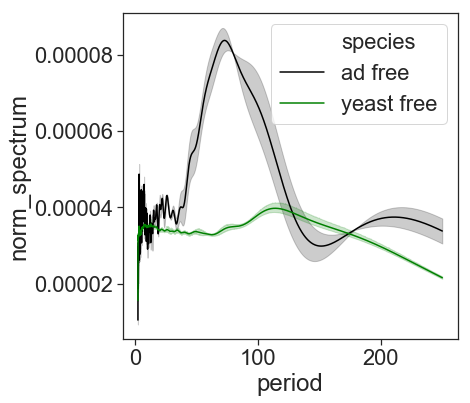

In [16]:
plt.subplots(figsize = (6,6))
sns.lineplot("period", "norm_spectrum", hue="species", data = df_free, palette = {"ad free":"black", "yeast free":"green"})

for ext in [".svg",".pdf"]:
    plt.savefig(
        "../plots/periodogram/free_ad_yeast{}".format(ext),
        dpi=300,
        bbox_inches="tight"
    )